<a href="https://colab.research.google.com/github/JayJay95/JavaByteCodeGenerator/blob/master/VulnerabilityClassifier_SimpleCNNwithDataLoader_Multiple_Batch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
%cd /content/drive/My\ Drive/After4thYear/Belfast/MSc\ Cybersec/Research\ Project/Colab Notebooks

/content/drive/My Drive/After4thYear/Belfast/MSc Cybersec/Research Project/Colab Notebooks


In [0]:
import os
import re
import fnmatch
import argparse
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data
from torch.autograd import Variable
import torch.optim as optim
import numpy as np
import test_cases
from copy import deepcopy
import pdb
import time
import matplotlib.pyplot as plt


In [0]:
clean_opseq_folder = '/content/drive/My Drive/After4thYear/Belfast/MSc Cybersec/Research Project/Colab Notebooks/Opseq/Clean_Opseq'
vuln_opseq_folder = '/content/drive/My Drive/After4thYear/Belfast/MSc Cybersec/Research Project/Colab Notebooks/Opseq/Vuln_Opseq'

In [0]:
parser = argparse.ArgumentParser(description='Vulnerability Classifier')
# parser.add_argument('--max_opcode_seq_len', action='store', type=int, help='use different versions of network', default=8192)
# parser.add_argument('--min_opcode_seq_len', action='store', type=int, help='use different versions of network', default=32)
parser.add_argument('--lr', action='store', type=float, help='use different versions of network', default=1e-5)
parser.add_argument('--epochs', action='store', type=int, help='use different versions of network', default=30)
opt = parser.parse_args('')
print(opt)

Namespace(epochs=30, lr=1e-05)


In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [0]:
def find_files(files, dirs=[], extensions=[]): # recursively find files in directories
    new_dirs = []
    for d in dirs:
        try:
            new_dirs += [ os.path.join(d, f) for f in os.listdir(d)] # check in all directories except testcasesupport 
        except OSError:
            if os.path.splitext(d)[1] in extensions:
                files.append(d)

    if new_dirs:
        find_files(files, new_dirs, extensions)
    else:
        return  

def read_file(filename):
    opcode_count = 0
    line_list = []
    with open(filename, mode='rt', encoding='utf8') as f:
        content = f.readlines()        
    for line in content:
        opcode_seq = []     
        for c in range(0, len(line) - 1, 2):
            #print(line[c:(c+2)],int(line[c:(c+2)], 16))
            opcode_seq.append(int(line[c:(c+2)], 16) + 1) # add one here so that the zero'th embedding is reserved for 'blank' i.e. no instruction whatsoever not even no-op			
            opcode_count += 1
            # to save training time we only read 
            # the first opt.max_opcode_seq_len opcodes of each file
            
            # if opcode_count >= opt.max_opcode_seq_len:
            #     return opcode_seq
        line_list.append(opcode_seq)
    return line_list

def read_dataset():
    vuln = []
    clean = []
    clean_opseq_files = []
    vuln_opseq_files = []
    # min_file_len = opt.min_opcode_seq_len #ignore opcode seq files shorter than this
    find_files(clean_opseq_files, dirs=[clean_opseq_folder], extensions=['.clean'])
    for clean_file_pathname in clean_opseq_files:
        tmp = read_file(clean_file_pathname)
        # if len(tmp) >= min_file_len:
        clean.append(tmp)
    
    find_files(vuln_opseq_files, dirs=[vuln_opseq_folder], extensions=['.vuln'])
    for vuln_file_pathname in vuln_opseq_files:
        tmp = read_file(vuln_file_pathname)
        # if len(tmp) >= min_file_len:
        vuln.append(tmp)
    
    # flatten vuln and clean lists
    new_vuln = []
    for x in vuln:
        for y in x:
            new_vuln.append(y)
    
    new_clean = []
    for x in clean:
        for y in x:
            new_clean.append(y)
    return new_vuln, new_clean

In [0]:
def split_dataset(vuln, clean):
    #split the dataset into train, val, test sets
    #return the concatenated dataset and
    #indicies pointing to the train,val,test samples

    vuln_label = 0
    clean_label = 1
    dataset = deepcopy(clean) + deepcopy(vuln) # concatenate original clean and original vuln samples
    trial_dataset = clean + vuln
    
    #pad with zeroes to make all sequences a standard length of 1000
    for list in trial_dataset:
        if len(list) < 1000:
            list.extend([0] * (1000- len(list)))
    
    final_vuln_list = []
    for vuln_list in vuln:
        inner_vuln_list = []
        inner_vuln_list.append(vuln_list)
        inner_vuln_list.append(vuln_label)
        final_vuln_list.append(inner_vuln_list)
             
    final_clean_list = []
    for clean_list in clean:
        inner_clean_list = []
        inner_clean_list.append(clean_list)
        inner_clean_list.append(clean_label)
        final_clean_list.append(inner_clean_list)
    
    # split vuln samples randomly
    first_vuln_split = int(0.8 * len(final_vuln_list))
    second_vuln_split = int(0.1 * len(final_vuln_list))
    third_vuln_split = int(len(final_vuln_list) - (first_vuln_split + second_vuln_split))
    vuln_training_dataset, vuln_validation_dataset, vuln_testing_dataset = torch.utils.data.random_split(final_vuln_list, [first_vuln_split, second_vuln_split, third_vuln_split])

    # split clean samples randomly
    first_clean_split = int(0.8 * len(final_clean_list))
    second_clean_split = int(0.1*len(final_clean_list))
    third_clean_split = int(len(final_clean_list) - (first_clean_split + second_clean_split))
    clean_training_dataset, clean_validation_dataset, clean_testing_dataset = torch.utils.data.random_split(final_clean_list, [first_clean_split, second_clean_split, third_clean_split])

    # merge both vuln & clean training sets
    training_set = clean_training_dataset + vuln_training_dataset

    # get indices and labels from training set
    train_inds=[]
    train_labels=[]
    training_counter = 0
    
    for list in training_set:
        train_inds.append(training_counter)
        training_counter+=1
        train_labels.append(list[1])
        
    # merge both vuln & clean validation sets
    validation_set = clean_validation_dataset + vuln_validation_dataset

    # get indices and labels from validation set
    val_inds = []
    val_labels = []
    training_set_length = len(training_set)
    for list in validation_set:
        val_inds.append(training_set_length)
        training_set_length += 1
        val_labels.append(list[1])

    # merge both vuln & clean testing sets
    testing_set = clean_testing_dataset + vuln_testing_dataset

    # get indices and labels from testing set
    test_inds = []
    test_labels = []
    validation_set_length = len(training_set) + len(validation_set)
    for list in testing_set:
        test_inds.append(validation_set_length)
        validation_set_length += 1
        test_labels.append(list[1])
    
    return trial_dataset, training_set, validation_set, testing_set


In [0]:
def evaluate_network_performance(predictions, ground_truth):
    # given an array with the predicted values and the correct values
    # calculate the precision, recall and f-score
    cm = get_confusion_matrix(predictions, ground_truth)
    TP = cm[0][0]
    FP = cm[0][1]
    FN = cm[1][0]
    TN = cm[1][1]

    precision = TP/(TP + FP + 1e-6)
    recall = TP/(TP + FN + 1e-6)
    classification_accuracy = (TP+TN) / (TP + TN + FP + FN + 1e-6)
    f_score = 2 * ((precision*recall)/(precision + recall))

    return precision, recall, f_score, classification_accuracy

In [0]:
class VulnerabilityDetectorNetwork(nn.Module):
    def __init__(self):
        super(VulnerabilityDetectorNetwork, self).__init__()

        self.num_of_embeddings = 205
        self.embedding_dimension = 8
        self.channels_in = 1
        self.channels_out = 64
        self.hidden_nodes = 16
        self.kernel_height_dimension = 8
        self.kernel_width_dimension = 8
        self.padding_height_dimension = 0
        self.padding_width_dimension = 0
        self.features_out = 2

        self.emb1 = nn.Embedding(self.num_of_embeddings, self.embedding_dimension)
        self.conv1 = nn.Conv2d(self.channels_in, self.channels_out, kernel_size=(self.kernel_height_dimension, self.kernel_width_dimension),
            padding=(self.padding_height_dimension, self.padding_width_dimension))
        self.lin1 = nn.Linear(self.channels_out, self.hidden_nodes)
        self.lin2 = nn.Linear(self.hidden_nodes, self.features_out)
        self.drop_out = nn.Dropout(0.5)

    def forward(self, x):
#         print(x.shape)
        x = self.emb1(x)
#         print(x.shape)        
        x = x.unsqueeze(1)
#         x = x.unsqueeze(0)
#         print(x.shape)
        x = self.conv1(x)
#         print(x.shape)
        x = F.relu(x)
#         print(x.shape)        
        x = torch.max(x,2)[0]
#         print(x.shape)
        x = self.drop_out(x)
#         print(x.shape)
        x = x.squeeze(2)
#         print(x.shape)
        x = self.lin1(x)
#         print(x.shape)
        x = self.lin2(x)
#         print(x.shape)
        return x

In [0]:
def get_confusion_matrix(preds, truth):
    flat_truth = torch.stack(truth).flatten()
    flat_preds = torch.stack(preds).flatten()
    K = len(np.unique(flat_truth)) # Number of classes 
    result = np.zeros((K, K))
    for i in range(len(flat_truth)):
        result[flat_preds[i]][flat_truth[i]] += 1
    confusion_matrix = result
    return confusion_matrix

In [0]:
def test_network(net, tvtLoader):
    
    criterion = nn.CrossEntropyLoss()

    test_loss = 0
    predictions = []
    labels = []

    with torch.no_grad():
#         for i in range(len(inds)):
        for i, (opsqs, lbls) in enumerate(tvtLoader):
            net.eval()
            opsqs = torch.stack(opsqs).flatten()
            opsqs_tensor = opsqs.type(torch.LongTensor)
            lbls = lbls.type(torch.LongTensor)
            output = net(opsqs_tensor.view(-1, 1000))
            val,idx = torch.max(output.data,1) # max pool - max over the rows
#             predictions.append(idx.item())
            predictions.append(idx)
            labels.append(lbls)

            test_loss = criterion(output, lbls).item()

        precision, recall, f_score, classification_accuracy = evaluate_network_performance(predictions, labels)

    return precision, recall, f_score, classification_accuracy


In [0]:
def train_network(net, trainLoader, valLoader):
    epochs_list = []
    train_acc_list = []
    val_acc_list = []
    loss_list = []
    
    optimizer = optim.Adam(net.parameters(), lr=opt.lr)
    criterion = nn.CrossEntropyLoss()

    num_training_epochs = opt.epochs

    for e in range(num_training_epochs):
        running_loss = 0

        for i, (opseqs, labels) in enumerate(trainLoader):
            net.train() # set network into training mode
            optimizer.zero_grad() #reset the optimizer before every loop
            
            opseqs = torch.stack(opseqs).flatten()
            opseqs_tensor = opseqs.type(torch.LongTensor)
            labels = labels.type(torch.LongTensor)
            
            net_output = net(opseqs_tensor.view(-1, 1000)) # forward pass of current training sample through the network
#           net_output = net(opseqs_tensor.unsqueeze(0))
            loss = criterion(net_output, labels) # how close network is to correct answer
            running_loss += loss.item()
            
            loss.backward() # back propagation step for whole net
            optimizer.step() # call optimizer to update network's parameters

        epoch_loss = running_loss/len(trainLoader)
        
        # for graph purposes
        epochs_list.append(e)
        loss_list.append(epoch_loss)
        
        print('iteration ', e, ' loss ', epoch_loss)
        print('          prec rec  f1   acc')
         
        precision, recall, f_score, classification_accuracy = test_network(net, trainLoader)
        train_acc_list.append(classification_accuracy)
        print('train set',"{0:.10f}".format(precision),"{0:.10f}".format(recall),"{0:.10f}".format(f_score),"{0:.10f}".format(classification_accuracy))
        
        precision, recall, f_score, classification_accuracy = test_network(net, valLoader)
        val_acc_list.append(classification_accuracy)
        print('val set  ',"{0:.10f}".format(precision),"{0:.10f}".format(recall),"{0:.10f}".format(f_score),"{0:.10f}".format(classification_accuracy))

        print()

    return net, epochs_list, train_acc_list, val_acc_list, loss_list


In [0]:
def createLoaders(train_set, val_set, test_set):
    trainLoader = torch.utils.data.DataLoader(train_set, batch_size = 1, shuffle = True, drop_last = True)
    valLoader = torch.utils.data.DataLoader(val_set, batch_size = 1, shuffle = True, drop_last = True)
    testLoader = torch.utils.data.DataLoader(test_set, batch_size = 1, shuffle = False, drop_last = True)
    return trainLoader, valLoader, testLoader


In [0]:
# def drawEpochsAccuracyGraph(x_epochs, y_train, y_val):
def drawEpochsAccuracyGraph():
    x_epochs = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]
    y_train = [0.6584145344733965, 0.6581882190147962, 0.6684478531380091, 0.6997548249110486, 0.75899918274019, 0.8151631357161607, 0.8259005469186409, 0.8388005280588572, 0.8574589803123474, 0.8703966806956637, 0.8943106808210938, 0.9007858175532686, 0.9041051109460728, 0.9055258691028413, 0.9070597849889098, 0.9087068586042786, 0.9098887282214134, 0.910882001623048, 0.9127805368590838, 0.9133086062624844, 0.9142515873399856, 0.9138869679900185, 0.9146664990140861, 0.9137109448555516, 0.9150814106881866, 0.9154208838760871, 0.9156597724157207, 0.9178223423534567, 0.9166907650604553, 0.9169170805190556, 0.918262400189624, 0.9180360847310237, 0.9182498271085906, 0.9182121078654906, 0.9183378386758241, 0.9189664927274915, 0.9186144464585577, 0.9186647387826912, 0.9184761425671909, 0.9191425158619584, 0.9192808197533253, 0.9197585968325925, 0.9194191236446921, 0.9200226315342929, 0.9200980700204929, 0.9195700006170923, 0.9205507009376935, 0.920638712504927, 0.9213553781238278, 0.9213302319617612]
    y_val = [0.6532541997129812, 0.6539583542245289, 0.6621064278581524, 0.6932904133695513, 0.7560607583989477, 0.8106830297947205, 0.8221506889827833, 0.8348254701906422, 0.8530328939892332, 0.8642993661739966, 0.8884418065699183, 0.8960869126952935, 0.8988029372398347, 0.9011165877777771, 0.902726083804172, 0.9035308318173694, 0.9047379538371655, 0.9058444823553119, 0.907956945889955, 0.908560506899853, 0.9096670354179994, 0.9090634744081014, 0.9101700029262478, 0.9097676289196491, 0.9108741574377955, 0.9111759379427445, 0.9114777184476935, 0.9143949299955342, 0.9124836534641904, 0.9128860274707891, 0.9143949299955342, 0.9140931494905851, 0.9139925559889355, 0.9137913689856361, 0.9138919624872858, 0.9147973040021328, 0.9140931494905851, 0.9143949299955342, 0.9140931494905851, 0.9144955234971838, 0.9149984910054322, 0.9151996780087315, 0.9150990845070819, 0.9155014585136806, 0.9159038325202792, 0.9150990845070819, 0.9163062065268779, 0.9163062065268779, 0.9171109545400753, 0.9173121415433747]
    plt.plot(x_epochs, y_train, label = "Train")
    plt.plot(x_epochs, y_val, label = "Val")

    # naming the axes
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    # title
    plt.title('Epochs vs Accuracy')
    plt.show()


In [0]:
# def drawEpochsLossGraph(x_epochs, y_loss):
def drawEpochsLossGraph():
    x_epochs = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]
    y_loss = [0.6967013273608522, 0.6745678188316391, 0.6603339555841392, 0.644877606510419, 0.6219225471516007, 0.5953997234708892, 0.5595094738751435, 0.5245517585736873, 0.47741589102812804, 0.433652581487062, 0.38796561680190367, 0.3495874577437324, 0.32915466132159205, 0.31719302154223594, 0.3063805344259221, 0.30067361567391676, 0.29598434268004364, 0.28857981132900434, 0.28737297505505643, 0.2814373940317472, 0.27817683185155595, 0.27397321228177046, 0.2725739207216876, 0.26785978908349817, 0.2669831220428971, 0.26483183544387445, 0.2633804116419876, 0.26159850699421805, 0.25787972398704156, 0.2584714300737994, 0.2539793785842021, 0.25174581744669067, 0.2525152710982629, 0.25077101407977664, 0.2513861546047585, 0.2481973221774613, 0.24791413625402378, 0.2445925750663176, 0.24443807470106782, 0.24571025536085364, 0.24276696698133685, 0.2415436951412054, 0.2394712409064405, 0.24034656522305042, 0.2396830300348922, 0.23964420243991855, 0.23741897556261227, 0.23677466290761653, 0.23669560364327336, 0.2371069494360628]
    plt.plot(x_epochs, y_loss, label = "Loss")
    # naming the axes
    plt.xlabel('Epochs')
    plt.ylabel('Loss (%)')
    plt.legend()

    # title
    plt.title('Epochs vs Loss')
    plt.show()


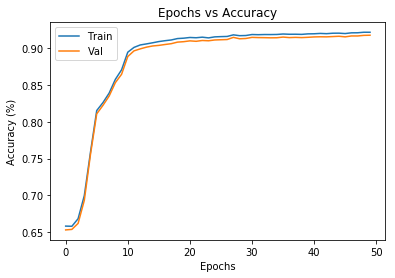

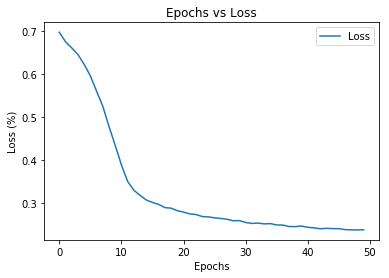

In [12]:
drawEpochsAccuracyGraph()
drawEpochsLossGraph()

In [0]:
def main():
    # create_clean_opseq_files() # should only run the first time this code is ran
    # print('Created clean opseq')
    # create_vuln_opseq_files() # should only run the first time this code is ran
    # print('Created vuln opseq')
    vuln, clean = read_dataset()

    dataset, train_set, val_set, test_set = split_dataset(vuln, clean)
#     pdb.set_trace()
    trainLoader, valLoader, testLoader = createLoaders(train_set, val_set, test_set)
    
    net = VulnerabilityDetectorNetwork()
    # net.to(device)
    print(net)
    print('started training network')
    before = time.time()
    
    net, epochs_list, train_acc_list, val_acc_list, loss_list = train_network(net, trainLoader, valLoader)
    print('started testing network')
    precision, recall, f_score, classification_accuracy = test_network(net, testLoader)
    print('test set',"{0:.10f}".format(precision),"{0:.10f}".format(recall),"{0:.10f}".format(f_score),"{0:.10f}".format(classification_accuracy))
    print()
    eval_time = time.time() - before
    print ("Time to run: ", eval_time)
    drawEpochsAccuracyGraph(epochs_list, train_acc_list, val_acc_list)
    drawEpochsLossGraph(epochs_list, loss_list)

In [0]:
# print('Running Test Case: Evaluation Function')
# test_case_result_eval_function = test_cases.test_evaluation_function(evaluate_network_performance)
# print('Test Case Result: ', test_case_result_eval_function)
# print()

# print('Running Test Case: Splitting Dataset')
# test_vuln,test_clean = read_dataset()
# test_case_result_split_dataset = test_cases.test_split_dataset(split_dataset, test_vuln, test_clean)
# print('Test Case Result: ', test_case_result_split_dataset)
# print()

# print('Running Test Case: Neural Network')
# test_case_result_network = test_cases.test_network(VulnerabilityDetectorNetwork)
# print('Test Case Result: ', test_case_result_network)
# print()

# if test_case_result_eval_function and test_case_result_split_dataset and test_case_result_network:
main()
# else:
#     print('one or more test cases failed - quitting')
#     quit()


In [0]:
# from __future__ import print_function, with_statement, division
# import copy
# import os
# import torch
# from tqdm.autonotebook import tqdm
# from torch.optim.lr_scheduler import _LRScheduler
# import matplotlib.pyplot as plt
# import pdb


# class LRFinder(object):
#     """Learning rate range test.

#     The learning rate range test increases the learning rate in a pre-training run
#     between two boundaries in a linear or exponential manner. It provides valuable
#     information on how well the network can be trained over a range of learning rates
#     and what is the optimal learning rate.

#     Arguments:
#         model (torch.nn.Module): wrapped model.
#         optimizer (torch.optim.Optimizer): wrapped optimizer where the defined learning
#             is assumed to be the lower boundary of the range test.
#         criterion (torch.nn.Module): wrapped loss function.
#         device (str or torch.device, optional): a string ("cpu" or "cuda") with an
#             optional ordinal for the device type (e.g. "cuda:X", where is the ordinal).
#             Alternatively, can be an object representing the device on which the
#             computation will take place. Default: None, uses the same device as `model`.
#         memory_cache (boolean): if this flag is set to True, `state_dict` of model and
#             optimizer will be cached in memory. Otherwise, they will be saved to files
#             under the `cache_dir`.
#         cache_dir (string): path for storing temporary files. If no path is specified,
#             system-wide temporary directory is used.
#             Notice that this parameter will be ignored if `memory_cache` is True.

#     Example:
#         >>> lr_finder = LRFinder(net, optimizer, criterion, device="cuda")
#         >>> lr_finder.range_test(dataloader, end_lr=100, num_iter=100)

#     Cyclical Learning Rates for Training Neural Networks: https://arxiv.org/abs/1506.01186
#     fastai/lr_find: https://github.com/fastai/fastai

#     """

#     def __init__(self, model, optimizer, criterion, device=None, memory_cache=True, cache_dir=None):
#         self.model = model
#         self.optimizer = optimizer
#         self.criterion = criterion
#         self.history = {"lr": [], "loss": []}
#         self.best_loss = None
#         self.memory_cache = memory_cache
#         self.cache_dir = cache_dir

#         # Save the original state of the model and optimizer so they can be restored if
#         # needed
#         self.model_device = next(self.model.parameters()).device
#         self.state_cacher = StateCacher(memory_cache, cache_dir=cache_dir)
#         self.state_cacher.store('model', self.model.state_dict())
#         self.state_cacher.store('optimizer', self.optimizer.state_dict())

#         # If device is None, use the same as the model
#         if device:
#             self.device = device
#         else:
#             self.device = self.model_device

#     def reset(self):
#         """Restores the model and optimizer to their initial states."""
#         self.model.load_state_dict(self.state_cacher.retrieve('model'))
#         self.optimizer.load_state_dict(self.state_cacher.retrieve('optimizer'))
#         self.model.to(self.model_device)

#     def range_test(
#         self,
#         train_loader,
#         val_loader=None,
#         end_lr=10,
#         num_iter=100,
#         step_mode="exp",
#         smooth_f=0.05,
#         diverge_th=5,
#     ):
#         """Performs the learning rate range test.

#         Arguments:
#             train_loader (torch.utils.data.DataLoader): the training set data laoder.
#             val_loader (torch.utils.data.DataLoader, optional): if `None` the range test
#                 will only use the training loss. When given a data loader, the model is
#                 evaluated after each iteration on that dataset and the evaluation loss
#                 is used. Note that in this mode the test takes significantly longer but
#                 generally produces more precise results. Default: None.
#             end_lr (float, optional): the maximum learning rate to test. Default: 10.
#             num_iter (int, optional): the number of iterations over which the test
#                 occurs. Default: 100.
#             step_mode (str, optional): one of the available learning rate policies,
#                 linear or exponential ("linear", "exp"). Default: "exp".
#             smooth_f (float, optional): the loss smoothing factor within the [0, 1[
#                 interval. Disabled if set to 0, otherwise the loss is smoothed using
#                 exponential smoothing. Default: 0.05.
#             diverge_th (int, optional): the test is stopped when the loss surpasses the
#                 threshold:  diverge_th * best_loss. Default: 5.

#         """
#         # Reset test results
#         self.history = {"lr": [], "loss": []}
#         self.best_loss = None

#         # Move the model to the proper device
#         self.model.to(self.device)

#         # Initialize the proper learning rate policy
#         if step_mode.lower() == "exp":
#             lr_schedule = ExponentialLR(self.optimizer, end_lr, num_iter)
#         elif step_mode.lower() == "linear":
#             lr_schedule = LinearLR(self.optimizer, end_lr, num_iter)
#         else:
#             raise ValueError("expected one of (exp, linear), got {}".format(step_mode))

#         if smooth_f < 0 or smooth_f >= 1:
#             raise ValueError("smooth_f is outside the range [0, 1[")

#         # Create an iterator to get data batch by batch
#         iterator = iter(train_loader)
#         for iteration in tqdm(range(num_iter)):
#             # Get a new set of inputs and labels
#             try:
#                 inputs, labels = next(iterator)				
				
#             except StopIteration:
#                 iterator = iter(train_loader)
#                 inputs, labels = next(iterator)

#             # Train on batch and retrieve loss
#             loss = self._train_batch(inputs, labels)
#             if val_loader:
#                 loss = self._validate(val_loader)

#             # Update the learning rate
#             lr_schedule.step()
#             self.history["lr"].append(lr_schedule.get_lr()[0])

#             # Track the best loss and smooth it if smooth_f is specified
#             if iteration == 0:
#                 self.best_loss = loss
#             else:
#                 if smooth_f > 0:
#                     loss = smooth_f * loss + (1 - smooth_f) * self.history["loss"][-1]
#                 if loss < self.best_loss:
#                     self.best_loss = loss

#             # Check if the loss has diverged; if it has, stop the test
#             self.history["loss"].append(loss)
#             if loss > diverge_th * self.best_loss:
#                 print("Stopping early, the loss has diverged")
#                 break

#         print("Learning rate search finished. See the graph with {finder_name}.plot()")

#     def _train_batch(self, inputs, labels):
#         # Set model to training mode
#         self.model.train()
# # 		inputs_tensor = inputs.type(torch.LongTensor)
# # 		inputs = torch.stack(inputs_tensor).flatten()
# # 		labels = labels.type(torch.LongTensor)
# #         pdb.set_trace()
        
#         # Forward pass
#         self.optimizer.zero_grad()
#         inputs = torch.stack(inputs).flatten()
#         inputs = inputs.type(torch.LongTensor)
#         # Move data to the correct device
#         inputs = inputs.to(self.device)
#         labels = labels.to(self.device)

#         outputs = self.model(inputs.view(-1, 1000))
#         loss = self.criterion(outputs, labels)

#         # Backward pass
#         loss.backward()
#         self.optimizer.step()

#         return loss.item()

#     def _validate(self, dataloader):
#         # Set model to evaluation mode and disable gradient computation
#         running_loss = 0
#         self.model.eval()
#         with torch.no_grad():
#             for inputs, labels in dataloader:
#                 inputs = torch.stack(inputs).flatten()
#                 inputs = inputs.type(torch.LongTensor)
#                 # Move data to the correct device
#                 inputs = inputs.to(self.device)
#                 labels = labels.to(self.device)

#                 # Forward pass and loss computation
#                 outputs = self.model(inputs.view(-1, 1000))
#                 loss = self.criterion(outputs, labels)
#                 running_loss += loss.item() * inputs.size(0)

#         return running_loss / len(dataloader.dataset)

#     def plot(self, skip_start=10, skip_end=5, log_lr=True):
#         """Plots the learning rate range test.

#         Arguments:
#             skip_start (int, optional): number of batches to trim from the start.
#                 Default: 10.
#             skip_end (int, optional): number of batches to trim from the start.
#                 Default: 5.
#             log_lr (bool, optional): True to plot the learning rate in a logarithmic
#                 scale; otherwise, plotted in a linear scale. Default: True.

#         """

#         if skip_start < 0:
#             raise ValueError("skip_start cannot be negative")
#         if skip_end < 0:
#             raise ValueError("skip_end cannot be negative")

#         # Get the data to plot from the history dictionary. Also, handle skip_end=0
#         # properly so the behaviour is the expected
#         lrs = self.history["lr"]
#         losses = self.history["loss"]
#         if skip_end == 0:
#             lrs = lrs[skip_start:]
#             losses = losses[skip_start:]
#         else:
#             lrs = lrs[skip_start:-skip_end]
#             losses = losses[skip_start:-skip_end]

#         # Plot loss as a function of the learning rate
#         plt.plot(lrs, losses)
#         if log_lr:
#             plt.xscale("log")
#         plt.xlabel("Learning rate")
#         plt.ylabel("Loss")
#         plt.show()


# class LinearLR(_LRScheduler):
#     """Linearly increases the learning rate between two boundaries over a number of
#     iterations.

#     Arguments:
#         optimizer (torch.optim.Optimizer): wrapped optimizer.
#         end_lr (float, optional): the initial learning rate which is the lower
#             boundary of the test. Default: 10.
#         num_iter (int, optional): the number of iterations over which the test
#             occurs. Default: 100.
#         last_epoch (int): the index of last epoch. Default: -1.

#     """

#     def __init__(self, optimizer, end_lr, num_iter, last_epoch=-1):
#         self.end_lr = end_lr
#         self.num_iter = num_iter
#         super(LinearLR, self).__init__(optimizer, last_epoch)

#     def get_lr(self):
#         curr_iter = self.last_epoch + 1
#         r = curr_iter / self.num_iter
#         return [base_lr + r * (self.end_lr - base_lr) for base_lr in self.base_lrs]


# class ExponentialLR(_LRScheduler):
#     """Exponentially increases the learning rate between two boundaries over a number of
#     iterations.

#     Arguments:
#         optimizer (torch.optim.Optimizer): wrapped optimizer.
#         end_lr (float, optional): the initial learning rate which is the lower
#             boundary of the test. Default: 10.
#         num_iter (int, optional): the number of iterations over which the test
#             occurs. Default: 100.
#         last_epoch (int): the index of last epoch. Default: -1.

#     """

#     def __init__(self, optimizer, end_lr, num_iter, last_epoch=-1):
#         self.end_lr = end_lr
#         self.num_iter = num_iter
#         super(ExponentialLR, self).__init__(optimizer, last_epoch)

#     def get_lr(self):
#         curr_iter = self.last_epoch + 1
#         r = curr_iter / self.num_iter
#         return [base_lr * (self.end_lr / base_lr) ** r for base_lr in self.base_lrs]


# class StateCacher(object):
#     def __init__(self, in_memory, cache_dir=None):
#         self.in_memory = in_memory
#         self.cache_dir = cache_dir

#         if self.cache_dir is None:
#             import tempfile
#             self.cache_dir = tempfile.gettempdir()
#         else:
#             if not os.path.isdir(self.cache_dir):
#                 raise ValueError('Given `cache_dir` is not a valid directory.')

#         self.cached = {}

#     def store(self, key, state_dict):
#         if self.in_memory:
#             self.cached.update({key: copy.deepcopy(state_dict)})
#         else:
#             fn = os.path.join(self.cache_dir, 'state_{}_{}.pt'.format(key, id(self)))
#             self.cached.update({key: fn})
#             torch.save(state_dict, fn)

#     def retrieve(self, key):
#         if key not in self.cached:
#             raise KeyError('Target {} was not cached.'.format(key))

#         if self.in_memory:
#             return self.cached.get(key)
#         else:
#             fn = self.cached.get(key)
#             if not os.path.exists(fn):
#                 raise RuntimeError('Failed to load state in {}. File does not exist anymore.'.format(fn))
#             state_dict = torch.load(fn, map_location=lambda storage, location: storage)
#             return state_dict

#     def __del__(self):
#         """Check whether there are unused cached files existing in `cache_dir` before
#         this instance being destroyed."""
#         if self.in_memory:
#             return

#         for k in self.cached:
#             if os.path.exists(self.cached[k]):
#                 os.remove(self.cached[k])


In [0]:
# vuln, clean = read_dataset()

# dataset, train_set, val_set, test_set = split_dataset(vuln, clean)
# trainLoader, valLoader, testLoader = createLoaders(train_set, val_set, test_set)
# net = VulnerabilityDetectorNetwork()
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(net.parameters(), lr=1e-7, weight_decay=1e-2)
# lr_finder = LRFinder(net, optimizer, criterion)
# lr_finder.range_test(trainLoader, end_lr=100, num_iter=100, step_mode="exp")


In [0]:
# lr_finder.plot()

In [0]:
# lr_finder.reset()

In [0]:
# lr_finder.range_test(trainLoader, val_loader=valLoader, end_lr=100, num_iter=100, step_mode="exp")

In [0]:
# lr_finder.plot(skip_end=0)

In [0]:
# lr_finder.reset()